## Using H1 fullsim as input

Setup for benchmarking, laptop vs GPU

Trying out things from Ben Nachman's example.

This uses the H1 fullsim MC as input.

Uses set of variables is E, pt, pz, Empz (redundant but useful?) for both HFS and electron as well as delta phi between HFS and electron.

Main development changes here:


Training target variable is log(x) instead of x





In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
from matplotlib import rc
from numpy import inf
import os

from os import listdir


import uproot3

import matplotlib as mpl



/Users/owen/.pyenv/versions/3.8.1/lib/python3.8/site-packages/pandas/compat/__init__.py:109: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:


has_gpu = False

#has_gpu = True



#--- Hyperparameter settings.

max_events =   120000
#max_events =   600000
#max_events =  3000000
#max_events = 15000000
#max_events = 1e9


learning_rate_setval = 1e-4
batch_size_setval = 128
max_epochs = 5000



In [3]:
%%time


input_file = 'h1-fullsim-2021-07-19/h1-fullsim-allfiles.root'

ur_file = uproot3.open(input_file)

print (ur_file.keys()) 
ur_tree = ur_file['Django/minitree']
print(ur_tree)
ur_tree.show()


#pandas_df   =  ur_tree.pandas.df(['*'], entrystop=max_events,flatten=True)

pandas_df   =  ur_tree.pandas.df(
    ['gene_px','gene_py','gene_pz',
     'e_px','e_py','e_pz',
     'HFS_px','HFS_py','HFS_pz','HFS_E',
     'gen_Q2',
     'gen_y',
     'Empz',
    ],
    entrystop=max_events,flatten=True)

print('\n\n Number of entries in pandas_df:  %d ' % pandas_df.shape[0] )


[b'Django;1']
<TTree b'minitree' at 0x00011277c430>
wgt                        (no streamer)              asdtype('>f4')
y_e                        (no streamer)              asdtype('>f4')
Q2_e                       (no streamer)              asdtype('>f4')
y_sigma                    (no streamer)              asdtype('>f4')
Q2_sigma                   (no streamer)              asdtype('>f4')
y_esigma                   (no streamer)              asdtype('>f4')
Q2_esigma                  (no streamer)              asdtype('>f4')
y_da                       (no streamer)              asdtype('>f4')
Q2_da                      (no streamer)              asdtype('>f4')
y_h                        (no streamer)              asdtype('>f4')
Q2_h                       (no streamer)              asdtype('>f4')
gen_x                      (no streamer)              asdtype('>f4')
gen_y                      (no streamer)              asdtype('>f4')
gen_Q2                     (no streamer)           

In [4]:
pandas_df

,gene_px,gene_py,gene_pz,e_px,e_py,e_pz,HFS_px,HFS_py,HFS_pz,HFS_E,gen_Q2,gen_y,Empz
entry,,,,,,,,,,,,,
0,3.283574,5.129409,-10.929905,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.343498,0.575322,0.000000
1,-5.531697,-3.367322,-2.631080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,240.616425,0.841318,0.000000
2,1.093026,7.108931,-14.778481,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.483292,0.434525,0.000000
3,4.031961,6.385868,-22.624577,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.741684,0.158043,0.000000
4,-8.811806,6.074530,-17.640022,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,165.209030,0.303108,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,-7.069151,0.120942,-20.542381,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,65.282227,0.234292,0.000000
119996,1.325970,11.543485,-18.148922,1.282752,11.028015,-17.323269,-3.740218,-10.264591,101.794151,117.759583,187.728165,0.280859,53.864372
119997,-6.433702,-2.534596,-16.819260,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,75.403999,0.218036,0.000000


In [5]:
n_before_empz = pandas_df.shape[0]
pandas_df = pandas_df.query('Empz>0')
n_after_empz = pandas_df.shape[0]
frac_after_empz = n_after_empz / n_before_empz
print('\n Fraction passing Empz>0 :  %d / %d = %8.4f' % (n_after_empz, n_before_empz, frac_after_empz))


 Fraction passing Empz>0 :  33301 / 120000 =   0.2775


In [6]:
pandas_df

,gene_px,gene_py,gene_pz,e_px,e_py,e_pz,HFS_px,HFS_py,HFS_pz,HFS_E,gen_Q2,gen_y,Empz
entry,,,,,,,,,,,,,
9,7.991641,41.257713,-8.253663,7.896643,40.699341,-8.267031,-8.369857,-41.172997,234.253250,239.119141,1908.471558,0.074625,55.407475
13,16.607563,7.054676,-2.758050,17.386559,7.380891,-3.096447,-12.415076,-13.259241,243.888321,280.390930,855.343079,0.619355,58.739544
20,-16.871563,29.083319,-11.572786,-16.517221,28.493423,-11.005733,3.738783,-14.740218,116.293289,119.632317,1324.020386,0.121437,49.227589
21,5.742672,-13.619509,-19.351875,5.832151,-13.807648,-19.644226,-6.197764,15.308520,78.376953,82.877342,275.943939,0.070863,48.854145
22,-38.008579,-59.328259,127.920113,-35.669365,-56.400394,122.574600,36.352924,56.511467,56.111095,90.331985,15122.667969,0.671715,51.219391
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119973,-3.574090,-9.039613,-14.980165,-3.622175,-9.217029,-15.271765,0.964755,13.512875,96.873451,124.042526,158.834732,0.405115,60.642506
119988,6.383735,3.585481,-10.876701,6.188062,3.469567,-10.524985,-4.923328,-3.644915,2.085040,32.431992,123.358688,0.565430,53.564667
119991,-4.787621,9.203158,-7.926117,-4.677593,8.996696,-7.810919,2.540452,-9.830969,46.014324,78.483078,283.134979,0.619878,53.079311


In [7]:
%%time

pandas_df.eval( 'gene_e = sqrt( gene_px*gene_px + gene_py*gene_py + gene_pz*gene_pz)', inplace=True )

pandas_df.eval( 'e_e = sqrt( e_px*e_px + e_py*e_py + e_pz*e_pz)', inplace=True )

pandas_df.eval( 'e_pt = sqrt( e_px*e_px + e_py*e_py)', inplace=True )

pandas_df.eval( 'e_phi = arctan2( e_py, e_px )', inplace=True )

pandas_df.eval( 'gene_pt = sqrt( gene_px*gene_px + gene_py*gene_py)', inplace=True )
pandas_df.eval( 'gene_phi = arctan2( gene_py, gene_px )', inplace=True )

pandas_df.eval( 'HFS_phi = arctan2( HFS_py, HFS_px )', inplace=True )
pandas_df.eval( 'HFS_pt = sqrt( HFS_px*HFS_px + HFS_py*HFS_py)', inplace=True )

pandas_df.eval( 'dphi = e_phi - HFS_phi', inplace=True )
pandas_df.eval( 'dphi = (abs(dphi)<3.14159265)*(dphi)+(dphi>3.14159265)*(dphi-2*3.14159265) + (dphi<-3.14159265)*(dphi+2*3.14159265)', inplace=True )
pandas_df.eval( 'dphi = (dphi>0)*dphi + (dphi<0)*(dphi+2*3.14159265)', inplace=True )


pandas_df.eval( 'gen_dphi = 3.141592653589793', inplace=True )

pandas_df.eval( 'HFS_Empz = HFS_E - HFS_pz', inplace=True )
pandas_df.eval( 'e_Empz = e_e - e_pz', inplace=True )

pandas_df.eval( 'gene_Empz = gene_e - gene_pz', inplace=True )

pandas_df.eval( 's = 4*27.6*920', inplace=True)
pandas_df.eval( 'gen_x = gen_Q2/(s*gen_y)', inplace=True)

pandas_df.eval( 'gen_log_x = log(gen_x)', inplace=True )

pandas_df.eval( 'rot_pt1 = 0.70710678 * HFS_pt - 0.70710678 * e_pt', inplace=True )
pandas_df.eval( 'rot_pt2 = 0.70710678 * HFS_pt + 0.70710678 * e_pt', inplace=True )

pandas_df.eval( 'rot_Empz1 = 0.70710678 * HFS_Empz - 0.70710678 * e_Empz', inplace=True )
pandas_df.eval( 'rot_Empz2 = 0.70710678 * HFS_Empz + 0.70710678 * e_Empz', inplace=True )


CPU times: user 70.5 ms, sys: 2.86 ms, total: 73.4 ms
Wall time: 72.2 ms


## Do some cleaning

In [8]:
%%time

pandas_df = pandas_df.query('Empz>45')


pandas_df = pandas_df.query('gen_y > 0 and gen_y < 1.0')


CPU times: user 16.5 ms, sys: 6.65 ms, total: 23.2 ms
Wall time: 21.3 ms


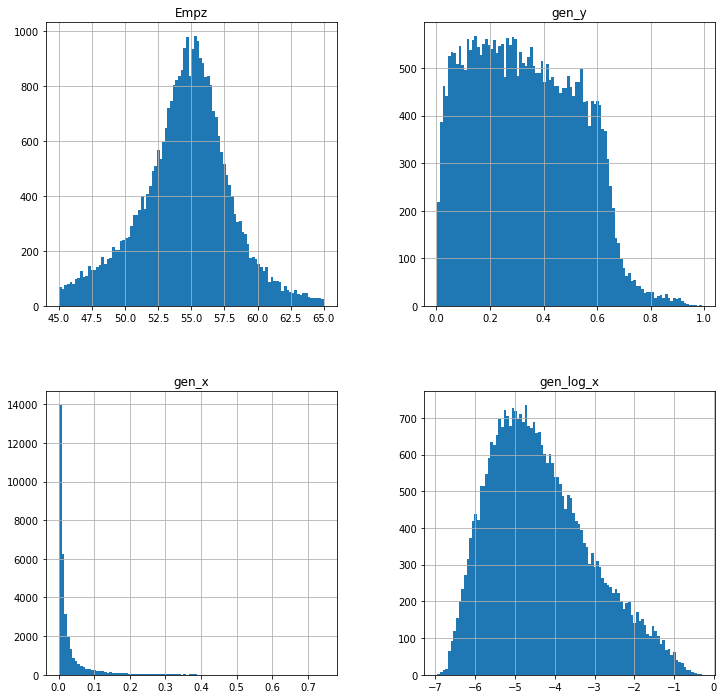

In [9]:
pandas_df.hist(figsize=(12,12), bins=100, column=['Empz','gen_y','gen_x','gen_log_x'])
plt.show()

In [10]:
pandas_df

,gene_px,gene_py,gene_pz,e_px,e_py,e_pz,HFS_px,HFS_py,HFS_pz,HFS_E,...,HFS_Empz,e_Empz,gene_Empz,s,gen_x,gen_log_x,rot_pt1,rot_pt2,rot_Empz1,rot_Empz2
entry,,,,,,,,,,,,,,,,,,,,,
9,7.991641,41.257713,-8.253663,7.896643,40.699341,-8.267031,-8.369857,-41.172997,234.253250,239.119141,...,4.865891,50.541573,51.081085,101568.0,0.251793,-1.379150,0.393705,59.024643,-32.297585,39.178993
13,16.607563,7.054676,-2.758050,17.386559,7.380891,-3.096447,-12.415076,-13.259241,243.888321,280.390930,...,36.502609,22.236927,21.011444,101568.0,0.013597,-4.297904,-0.511988,26.200180,10.087359,41.535122
20,-16.871563,29.083319,-11.572786,-16.517221,28.493423,-11.005733,3.738783,-14.740218,116.293289,119.632317,...,3.339027,45.730652,47.131447,101568.0,0.107346,-2.231695,-12.535378,34.041309,-29.975403,34.697502
21,5.742672,-13.619509,-19.351875,5.832151,-13.807648,-19.644226,-6.197764,15.308520,78.376953,82.877342,...,4.500389,44.353752,43.702736,101568.0,0.038339,-3.261283,1.079546,22.276957,-28.180584,34.545094
22,-38.008579,-59.328259,127.920113,-35.669365,-56.400394,122.574600,36.352924,56.511467,56.111095,90.331985,...,34.220890,16.988434,18.121147,101568.0,0.221660,-1.506612,0.326149,94.701012,12.185186,36.210457
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119973,-3.574090,-9.039613,-14.980165,-3.622175,-9.217029,-15.271765,0.964755,13.512875,96.873451,124.042526,...,27.169075,33.473427,32.837769,101568.0,0.003860,-5.557035,2.576733,16.582001,-4.457850,42.880722
119988,6.383735,3.585481,-10.876701,6.188062,3.469567,-10.524985,-4.923328,-3.644915,2.085040,32.431992,...,30.346951,23.217712,23.988161,101568.0,0.002148,-6.143219,-0.684928,9.348019,5.041132,37.875938
119991,-4.787621,9.203158,-7.926117,-4.677593,8.996696,-7.810919,2.540452,-9.830969,46.014324,78.483078,...,32.468754,20.610561,20.981491,101568.0,0.004497,-5.404328,0.009806,14.349988,8.385008,37.532745


## Set up machine learning stuff

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#-- Ben suggested to try this.  2021-08-07
from tensorflow.keras.callbacks import EarlyStopping
earlystopping = EarlyStopping(patience=10,
               verbose=True,
               restore_best_weights=True)

import os

print(tf.config.list_physical_devices())

if has_gpu :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    physical_devices = tf.config.list_physical_devices('GPU') 
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

#####physical_devices = tf.config.list_physical_devices('CPU') 




[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


## Test with gen electron vars only

Should be a slam dunk.

In [12]:
X = np.c_[ 
          pandas_df['gene_pz'].to_numpy(),
          pandas_df['gene_e'].to_numpy(),
          pandas_df['gene_pt'].to_numpy(),
          pandas_df['gene_Empz'].to_numpy(),
         ]

#Y = pandas_df['gen_x'].to_numpy()
Y = pandas_df['gen_log_x'].to_numpy()

scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Y = Y.reshape(-1,1)
scalerY = StandardScaler()
scalerY.fit(Y)
Y = scalerY.transform(Y)

GY = pandas_df['gen_y'].to_numpy()

print('\n\n Shape of X')
print( X.shape )

print('\n\n Shape of Y')
print( Y.shape )



 Shape of X
(33276, 4)


 Shape of Y
(33276, 1)


In [13]:
X_train, X_test, Y_train, Y_test, GY_train, GY_test = train_test_split( X, Y, GY, test_size=0.5)

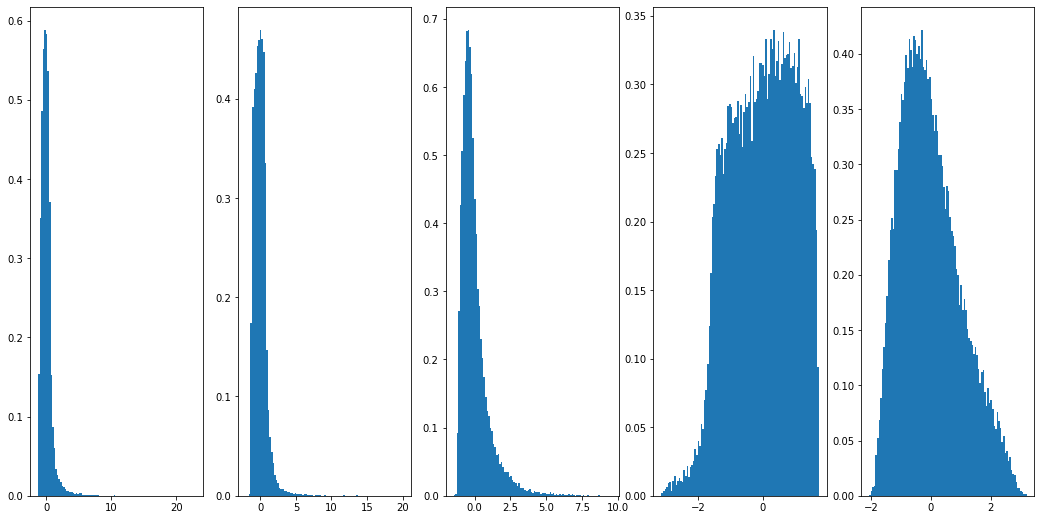

In [14]:
fig,ax = plt.subplots(1,5,figsize=(18,9))
for i in range(4):
    ax[i].hist( X[:,i],density=True,bins=100)

ax[4].hist( Y[:,0],density=True,bins=100)
plt.show()

In [15]:
model = Sequential()
model.add(Dense(64, input_dim=4, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='selu'))
model.add(Dropout(0.2))
#model.add(Dense(256, activation='selu'))
#model.add(Dropout(0.1))
#model.add(Dense(128, activation='selu'))
#model.add(Dropout(0.1))
model.add(Dense(64, activation='selu'))
model.add(Dense(1, activation='linear'))

#opt = tf.keras.optimizers.Adam(learning_rate=1e-5)
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss = tf.keras.losses.Huber()

model.compile(loss=myloss, optimizer=opt, metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
____________________________________________________

In [16]:
%%time

hist = model.fit(
    X_train, Y_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X_test,Y_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
130/130 [==============================] - 1s 2ms/step - loss: 0.1580 - accuracy: 0.0000e+00 - val_loss: 0.0340 - val_accuracy: 0.0000e+00
Epoch 2/5000
130/130 [==============================] - 0s 2ms/step - loss: 0.0595 - accuracy: 0.0000e+00 - val_loss: 0.0275 - val_accuracy: 0.0000e+00
Epoch 3/5000
130/130 [==============================] - 0s 2ms/step - loss: 0.0484 - accuracy: 0.0000e+00 - val_loss: 0.0255 - val_accuracy: 0.0000e+00
Epoch 4/5000
130/130 [==============================] - 0s 2ms/step - loss: 0.0440 - accuracy: 0.0000e+00 - val_loss: 0.0223 - val_accuracy: 0.0000e+00
Epoch 5/5000
130/130 [==============================] - 0s 2ms/step - loss: 0.0388 - accuracy: 0.0000e+00 - val_loss: 0.0214 - val_accuracy: 0.0000e+00
Epoch 6/5000
130/130 [==============================] - 0s 2ms/step - loss: 0.0360 - accuracy: 0.0000e+00 - val_loss: 0.0204 - val_accuracy: 0.0000e+00
Epoch 7/5000
130/130 [==============================] - 0s 2ms/step - loss: 0.0339 - acc

130/130 [==============================] - 0s 2ms/step - loss: 0.0128 - accuracy: 0.0000e+00 - val_loss: 0.0081 - val_accuracy: 0.0000e+00
Epoch 55/5000
130/130 [==============================] - 0s 2ms/step - loss: 0.0126 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 56/5000
130/130 [==============================] - 0s 1ms/step - loss: 0.0125 - accuracy: 0.0000e+00 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 57/5000
130/130 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.0000e+00 - val_loss: 0.0079 - val_accuracy: 0.0000e+00
Epoch 58/5000
130/130 [==============================] - 0s 2ms/step - loss: 0.0122 - accuracy: 0.0000e+00 - val_loss: 0.0077 - val_accuracy: 0.0000e+00
Epoch 59/5000
130/130 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 0.0000e+00 - val_loss: 0.0080 - val_accuracy: 0.0000e+00
Epoch 60/5000
130/130 [==============================] - 0s 2ms/step - loss: 0.0121 - accuracy: 

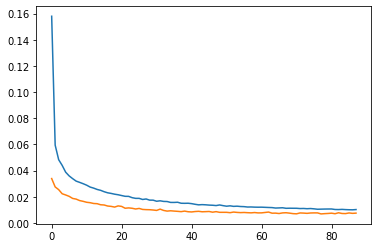

In [17]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

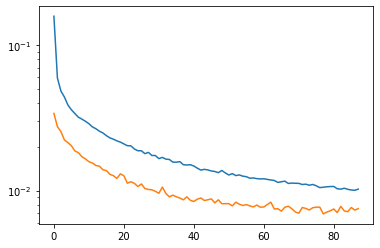

In [18]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')

In [19]:
mypreds = model.predict(X_test,batch_size=1000)

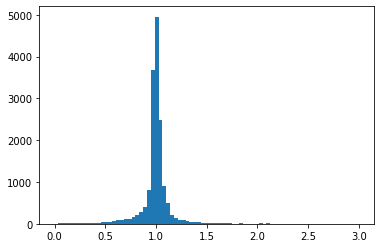

In [20]:
_,_,_=plt.hist(mypreds[:,0]/Y_test[:,0],bins=np.linspace(0,3,80))

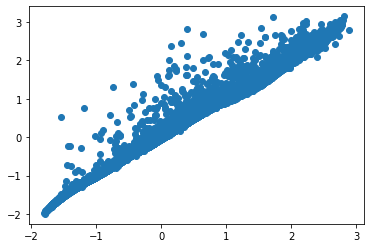

In [21]:
plt.scatter(mypreds[:,0],Y_test[:,0])

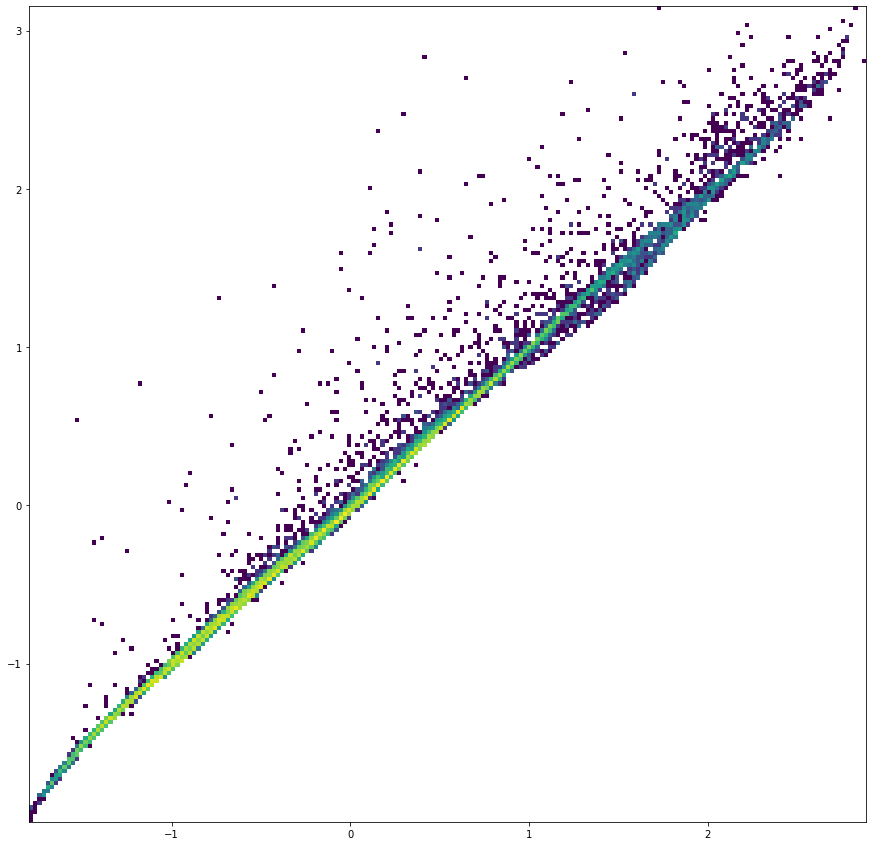

In [22]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds[:,0],Y_test[:,0],bins=200, norm=mpl.colors.LogNorm())
plt.show()

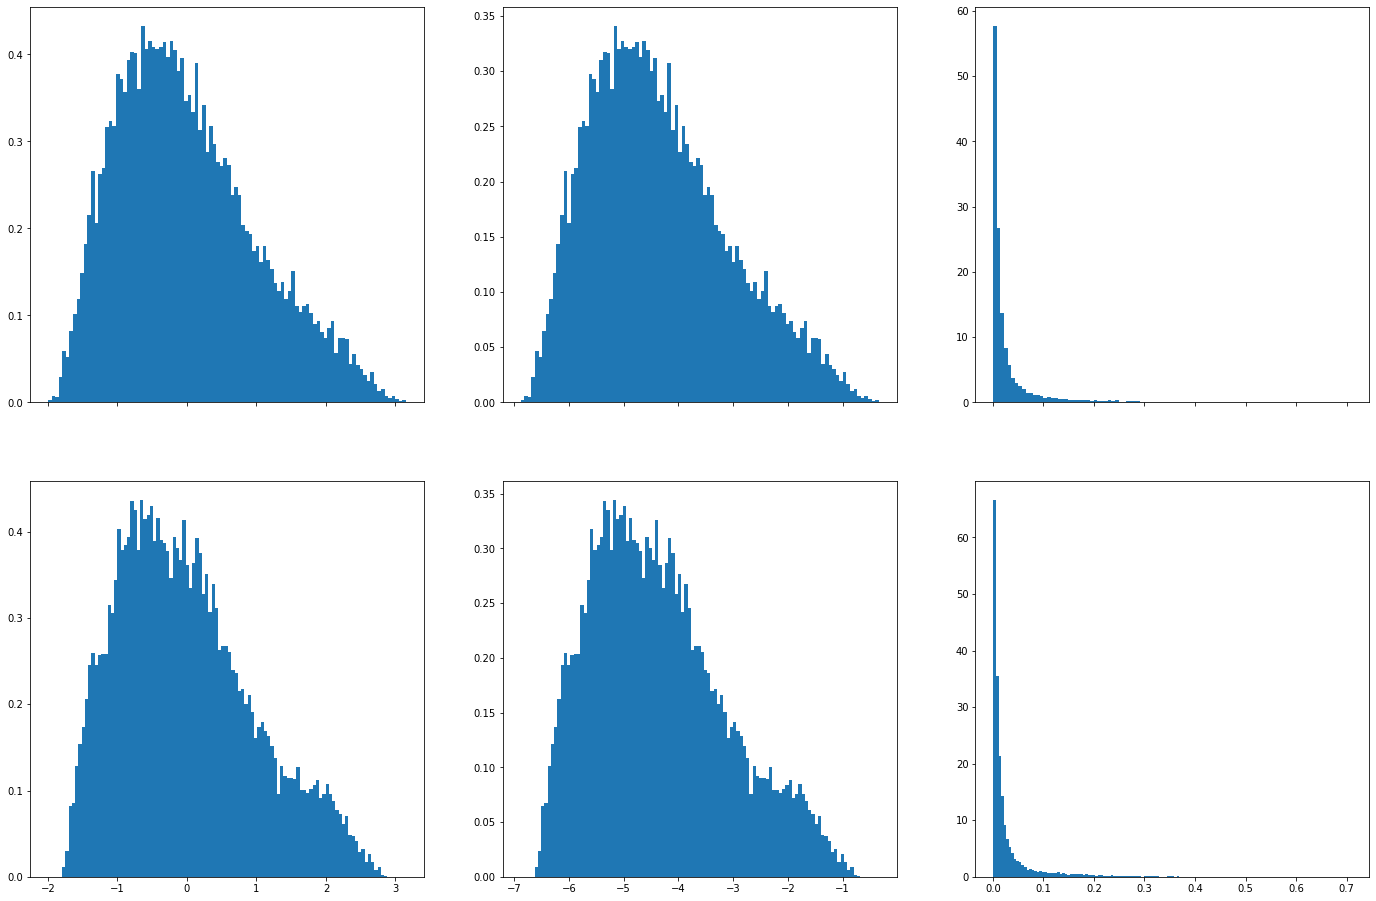

In [23]:
fig,ax = plt.subplots(2,3,figsize=(24,16), sharex='col')

ax[0][0].hist(Y_test[:,0],density=True,bins=100)
ax[0][1].hist(scalerY.inverse_transform(Y_test)[:,0],density=True,bins=100)
ax[0][2].hist(np.exp(scalerY.inverse_transform(Y_test)[:,0]),density=True,bins=100)

ax[1][0].hist(mypreds[:,0],density=True,bins=100)
ax[1][1].hist(scalerY.inverse_transform(mypreds)[:,0],density=True,bins=100)
ax[1][2].hist(np.exp(scalerY.inverse_transform(mypreds)[:,0]),density=True,bins=100)

plt.show()

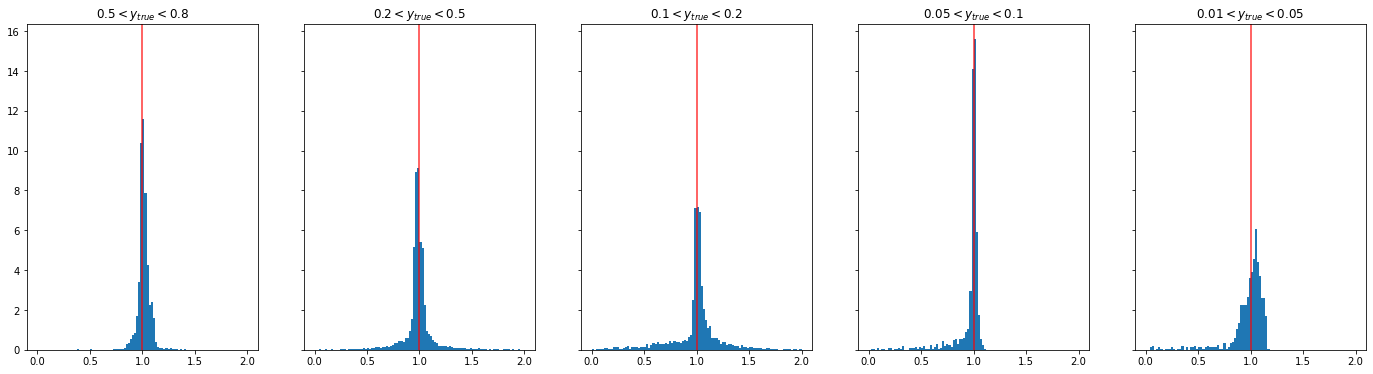

In [24]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()



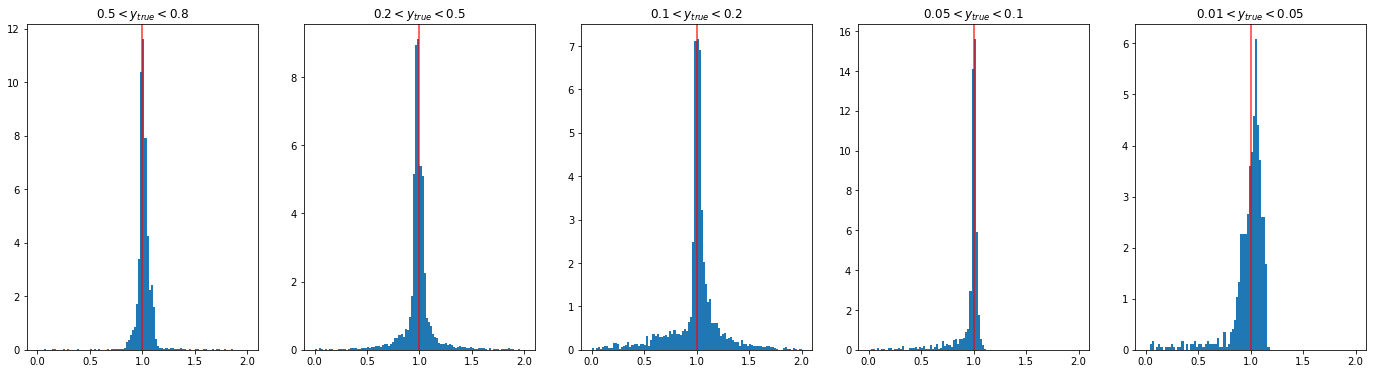

In [25]:
fig,ax = plt.subplots(1,5,figsize=(24,6))

ax[0].hist(mypreds[:,0][(GY_test > 0.5)*(GY_test < 0.8)]/Y_test[(GY_test > 0.5)*(GY_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds[:,0][(GY_test > 0.2)*(GY_test < 0.5)]/Y_test[(GY_test > 0.2)*(GY_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds[:,0][(GY_test > 0.1)*(GY_test < 0.2)]/Y_test[(GY_test > 0.1)*(GY_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds[:,0][(GY_test > 0.05)*(GY_test < 0.1)]/Y_test[(GY_test > 0.05)*(GY_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds[:,0][(GY_test > 0.01)*(GY_test < 0.05)]/Y_test[(GY_test > 0.01)*(GY_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)

plt.show()

## Conclusions on gen e vars only

Works, but sensitive to size of training sample and learning rate.  Can get artifacts if those are not right.

## Test with reco e vars only

This should be similar to the simple e method results.

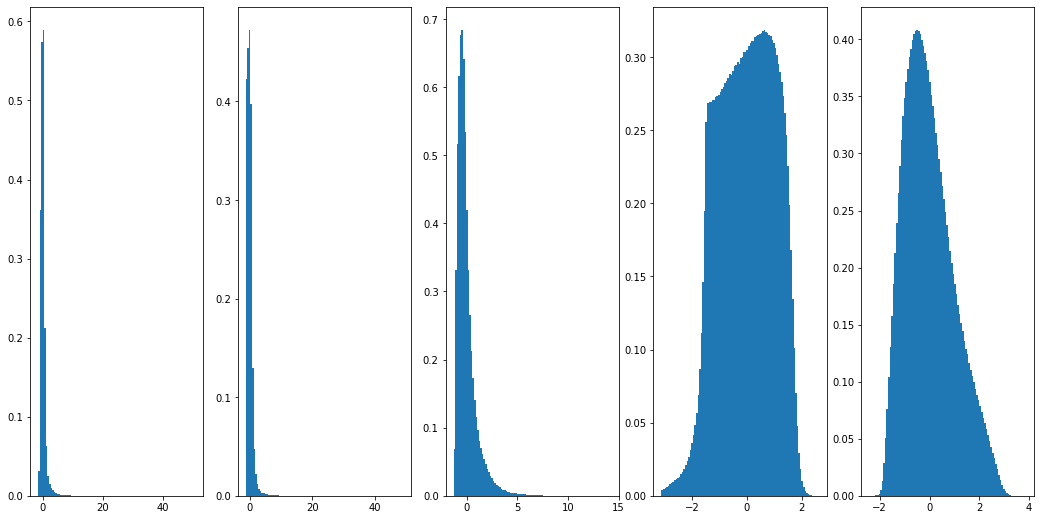

In [23]:
X2 = np.c_[ 
          pandas_df['e_pz'].to_numpy(),
          pandas_df['e_e'].to_numpy(),
          pandas_df['e_pt'].to_numpy(),
          pandas_df['e_Empz'].to_numpy(),
         ]

Y2 = pandas_df['gen_log_x'].to_numpy()

scaler2 = StandardScaler()
scaler2.fit(X2)
X2 = scaler.transform(X2)

Y2 = Y2.reshape(-1,1)
scalerY2 = StandardScaler()
scalerY2.fit(Y2)
Y2 = scalerY2.transform(Y2)

GY2 = pandas_df['gen_y'].to_numpy()

X2_train, X2_test, Y2_train, Y2_test, GY2_train, GY2_test = train_test_split( X2, Y2, GY2, test_size=0.5)

fig,ax = plt.subplots(1,5,figsize=(18,9))
for i in range(4):
    ax[i].hist( X2[:,i],density=True,bins=100)

ax[4].hist( Y2[:,0],density=True,bins=100)
plt.show()

In [24]:
model2 = Sequential()
model2.add(Dense(64, input_dim=4, activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(128, activation='selu'))
model2.add(Dropout(0.2))
#model2.add(Dense(256, activation='selu'))
#model2.add(Dropout(0.1))
#model2.add(Dense(128, activation='selu'))
#model2.add(Dropout(0.1))
model2.add(Dense(64, activation='selu'))
model2.add(Dense(1, activation='linear'))

opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss2 = tf.keras.losses.Huber()

model2.compile(loss=myloss2, optimizer=opt2, metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                320       
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
__________________________________________________

In [25]:
%%time

hist2 = model2.fit(
    X2_train, Y2_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X2_test,Y2_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
21403/21403 [==============================] - 49s 2ms/step - loss: 0.0295 - accuracy: 3.6503e-07 - val_loss: 0.0270 - val_accuracy: 0.0000e+00
Epoch 2/5000
21403/21403 [==============================] - 53s 2ms/step - loss: 0.0254 - accuracy: 3.6503e-07 - val_loss: 0.0274 - val_accuracy: 0.0000e+00
Epoch 3/5000
21403/21403 [==============================] - 49s 2ms/step - loss: 0.0249 - accuracy: 3.6503e-07 - val_loss: 0.0264 - val_accuracy: 0.0000e+00
Epoch 4/5000
21403/21403 [==============================] - 71s 3ms/step - loss: 0.0247 - accuracy: 3.6503e-07 - val_loss: 0.0264 - val_accuracy: 0.0000e+00
Epoch 5/5000
21403/21403 [==============================] - 68s 3ms/step - loss: 0.0246 - accuracy: 3.6503e-07 - val_loss: 0.0273 - val_accuracy: 0.0000e+00
Epoch 6/5000
21403/21403 [==============================] - 53s 2ms/step - loss: 0.0245 - accuracy: 3.6503e-07 - val_loss: 0.0269 - val_accuracy: 0.0000e+00
Epoch 7/5000
21403/21403 [==============================] 

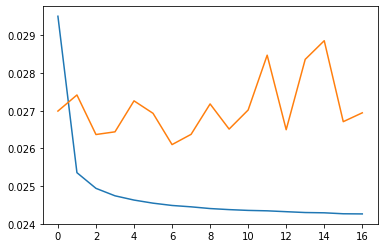

In [26]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])

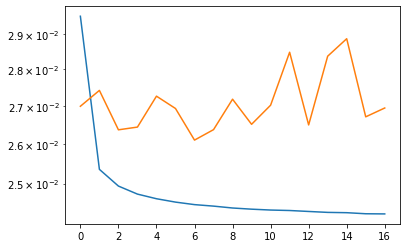

In [27]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.yscale('log')

In [28]:
mypreds2 = model2.predict(X2_test,batch_size=1000)

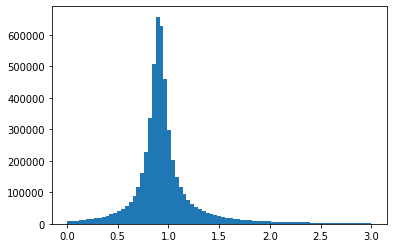

In [29]:
_,_,_=plt.hist(mypreds2[:,0]/Y2_test[:,0],bins=np.linspace(0,3,80))

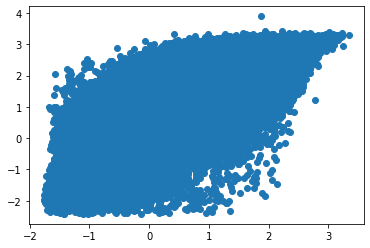

In [30]:
plt.scatter(mypreds2[:,0],Y2_test[:,0])

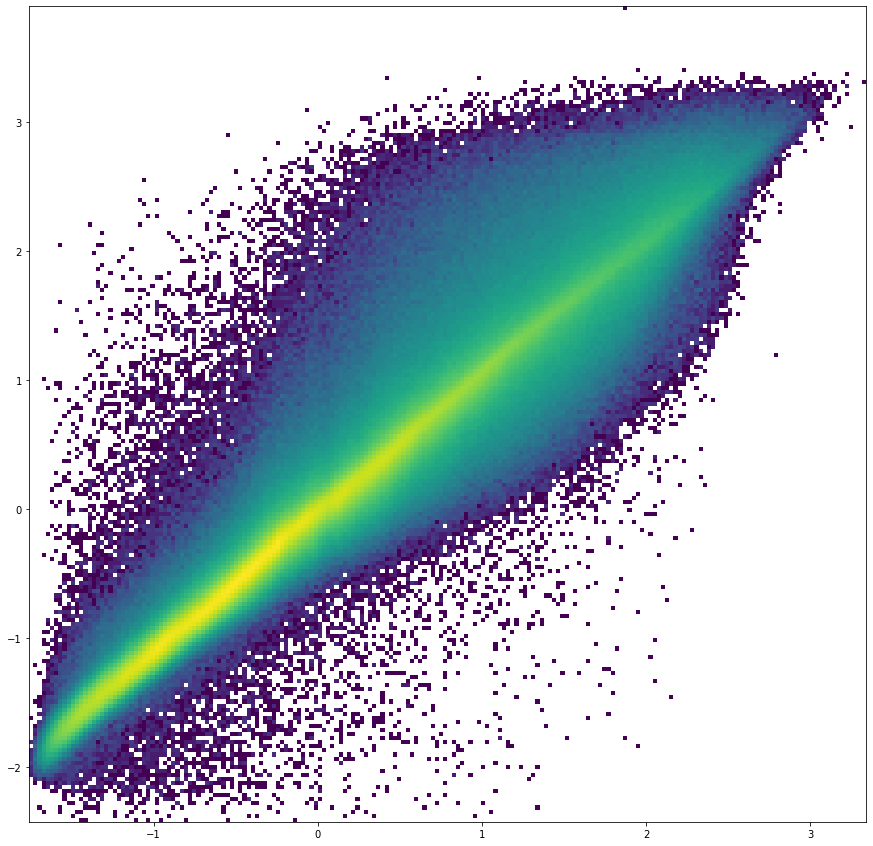

In [31]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds2[:,0],Y2_test[:,0],bins=200, norm=mpl.colors.LogNorm())
plt.show()

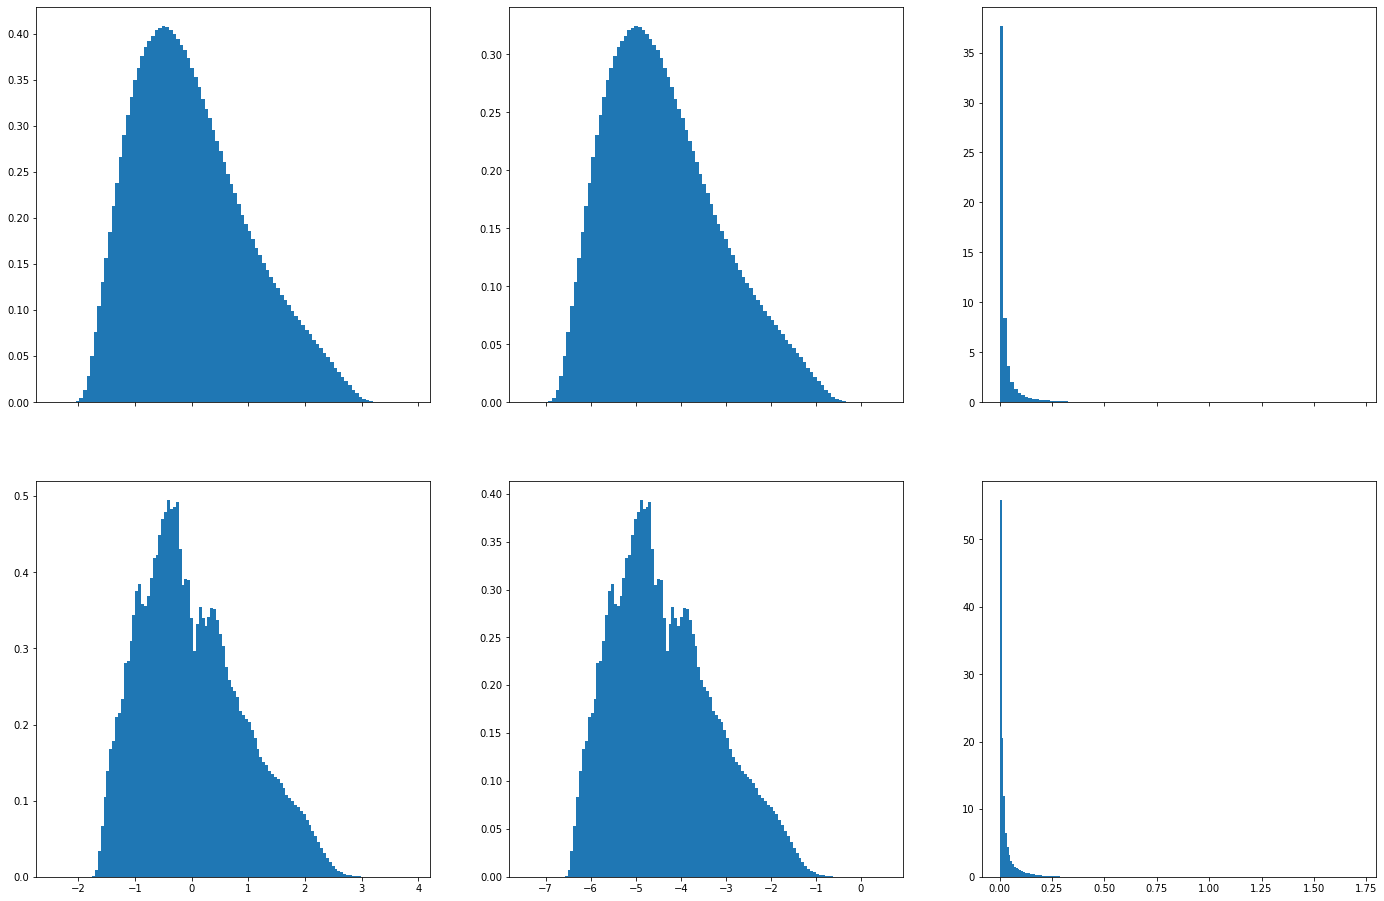

In [32]:
fig,ax = plt.subplots(2,3,figsize=(24,16),sharex='col')

ax[0][0].hist(Y2_test[:,0],density=True,bins=100)
ax[0][1].hist(scalerY2.inverse_transform(Y2_test)[:,0],density=True,bins=100)
ax[0][2].hist(np.exp(scalerY2.inverse_transform(Y2_test)[:,0]),density=True,bins=100)

ax[1][0].hist(mypreds2[:,0],density=True,bins=100)
ax[1][1].hist(scalerY2.inverse_transform(mypreds2)[:,0],density=True,bins=100)
ax[1][2].hist(np.exp(scalerY2.inverse_transform(mypreds2)[:,0]),density=True,bins=100)

plt.show()

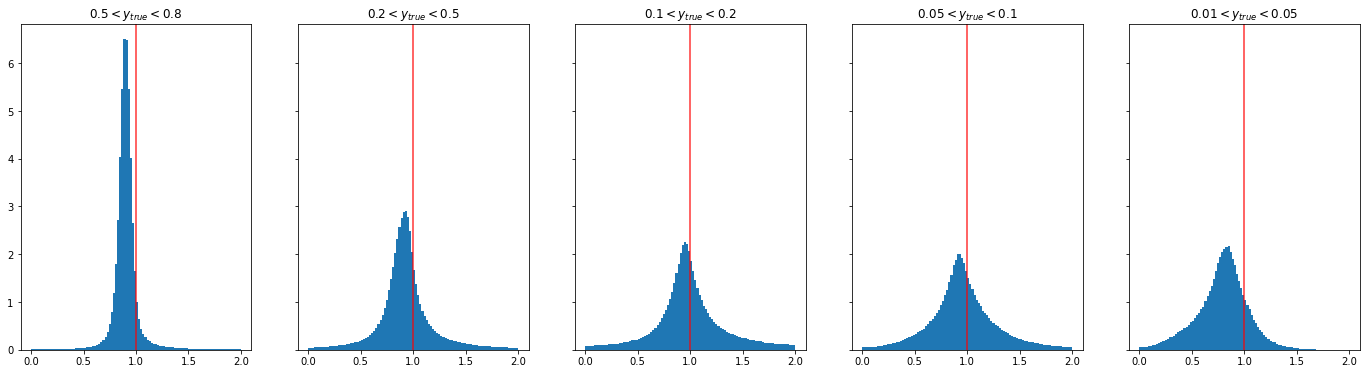

In [33]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds2[:,0][(GY2_test > 0.5)*(GY2_test < 0.8)]/Y2_test[(GY2_test > 0.5)*(GY2_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds2[:,0][(GY2_test > 0.2)*(GY2_test < 0.5)]/Y2_test[(GY2_test > 0.2)*(GY2_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds2[:,0][(GY2_test > 0.1)*(GY2_test < 0.2)]/Y2_test[(GY2_test > 0.1)*(GY2_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds2[:,0][(GY2_test > 0.05)*(GY2_test < 0.1)]/Y2_test[(GY2_test > 0.05)*(GY2_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds2[:,0][(GY2_test > 0.01)*(GY2_test < 0.05)]/Y2_test[(GY2_test > 0.01)*(GY2_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()




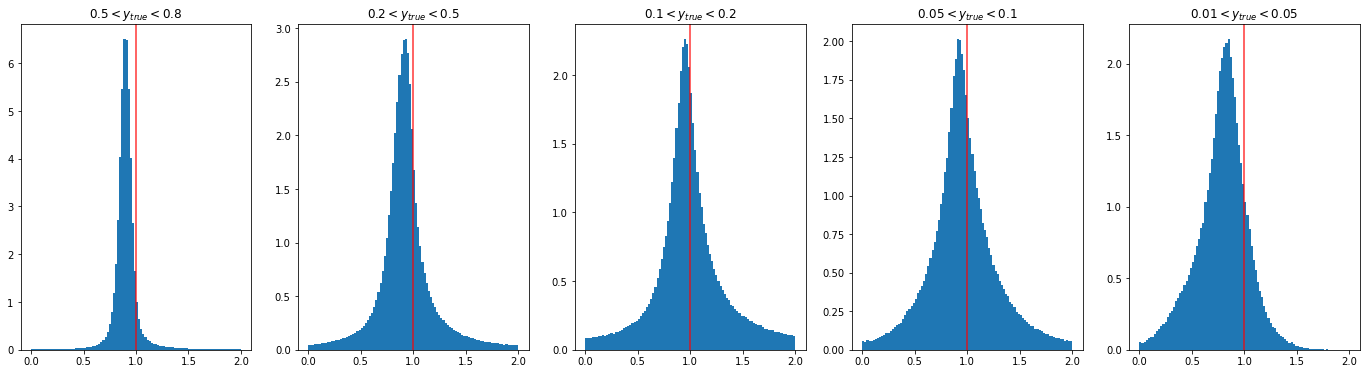

In [34]:
fig,ax = plt.subplots(1,5,figsize=(24,6))

ax[0].hist(mypreds2[:,0][(GY2_test > 0.5)*(GY2_test < 0.8)]/Y2_test[(GY2_test > 0.5)*(GY2_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds2[:,0][(GY2_test > 0.2)*(GY2_test < 0.5)]/Y2_test[(GY2_test > 0.2)*(GY2_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds2[:,0][(GY2_test > 0.1)*(GY2_test < 0.2)]/Y2_test[(GY2_test > 0.1)*(GY2_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds2[:,0][(GY2_test > 0.05)*(GY2_test < 0.1)]/Y2_test[(GY2_test > 0.05)*(GY2_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds2[:,0][(GY2_test > 0.01)*(GY2_test < 0.05)]/Y2_test[(GY2_test > 0.01)*(GY2_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Conclusions on reco electron vars only

More or less looks as expected.  Resolution gets very poor at low y.

## Now feed in reco electron and reco HFS

This includes a variable transformation that decorrelates pt and Empz between the HFS and the electron.

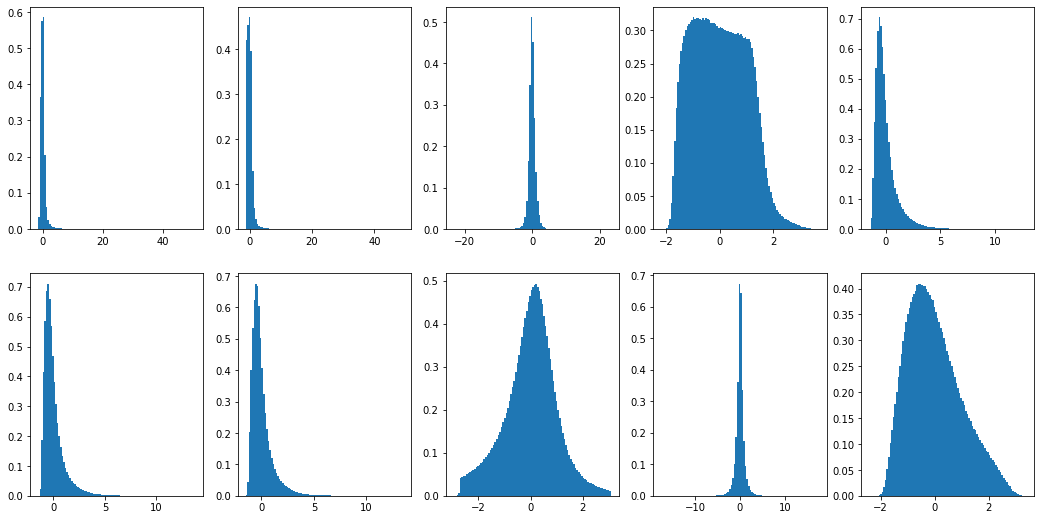

In [9]:
X3 = np.c_[ 
          pandas_df['e_pz'].to_numpy(),
          pandas_df['e_e'].to_numpy(),
          pandas_df['rot_pt1'].to_numpy(),
          pandas_df['rot_Empz1'].to_numpy(),
          pandas_df['HFS_pz'].to_numpy(),
          pandas_df['HFS_E'].to_numpy(),
          pandas_df['rot_pt2'].to_numpy(),
          pandas_df['rot_Empz2'].to_numpy(),
          pandas_df['dphi'].to_numpy(),
         ]

Y3 = pandas_df['gen_log_x'].to_numpy()

scaler3 = StandardScaler()
scaler3.fit(X3)
X3 = scaler3.transform(X3)

Y3 = Y3.reshape(-1,1)
scalerY3 = StandardScaler()
scalerY3.fit(Y3)
Y3 = scalerY3.transform(Y3)

GY3 = pandas_df['gen_y'].to_numpy()

X3_train, X3_test, Y3_train, Y3_test, GY3_train, GY3_test = train_test_split( X3, Y3, GY3, test_size=0.5)

fig,ax = plt.subplots(2,5,figsize=(18,9))
for i in range(5):
    ax[0][i].hist( X3[:,i],density=True,bins=100)
for i in range(4):
    ax[1][i].hist( X3[:,i+5],density=True,bins=100)

ax[1][4].hist( Y3[:,0],density=True,bins=100)
plt.show()

In [10]:
model3 = Sequential()

model3.add(Dense(64, input_dim=9, activation='relu'))
model3.add(Dropout(0.1))


#model3.add(Dense(128, activation='selu'))
#model3.add(Dropout(0.1))
#model3.add(Dense(256, activation='selu'))
#model3.add(Dropout(0.1))
#model3.add(Dense(256, activation='selu'))
#model3.add(Dropout(0.1))
#model3.add(Dense(256, activation='selu'))
#model3.add(Dropout(0.1))
#model3.add(Dense(128, activation='selu'))
#model3.add(Dropout(0.1))

model3.add(Dense(128, activation='selu'))
model3.add(Dropout(0.1))
model3.add(Dense(512, activation='selu'))
model3.add(Dropout(0.1))
model3.add(Dense(512, activation='selu'))
model3.add(Dropout(0.1))
model3.add(Dense(256, activation='selu'))
model3.add(Dropout(0.1))
model3.add(Dense(128, activation='selu'))
model3.add(Dropout(0.1))



model3.add(Dense(64, activation='selu'))
model3.add(Dense(1, activation='linear'))

opt3 = tf.keras.optimizers.Adam(learning_rate=learning_rate_setval)
myloss3 = tf.keras.losses.Huber()

model3.compile(loss=myloss3, optimizer=opt3, metrics=['accuracy'])

model3.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               2

In [11]:
%%time

hist3 = model3.fit(
    X3_train, Y3_train, 
    epochs=max_epochs, batch_size=batch_size_setval, verbose=1, 
    validation_data=(X3_test,Y3_test), 
    callbacks=[earlystopping] )

Epoch 1/5000
10765/10765 [==============================] - 84s 8ms/step - loss: 0.0254 - accuracy: 0.0000e+00 - val_loss: 0.0217 - val_accuracy: 0.0000e+00
Epoch 2/5000
10765/10765 [==============================] - 103s 10ms/step - loss: 0.0125 - accuracy: 0.0000e+00 - val_loss: 0.0173 - val_accuracy: 0.0000e+00
Epoch 3/5000
10765/10765 [==============================] - 105s 10ms/step - loss: 0.0109 - accuracy: 0.0000e+00 - val_loss: 0.0179 - val_accuracy: 0.0000e+00
Epoch 4/5000
10765/10765 [==============================] - 109s 10ms/step - loss: 0.0103 - accuracy: 0.0000e+00 - val_loss: 0.0136 - val_accuracy: 0.0000e+00
Epoch 5/5000
10765/10765 [==============================] - 111s 10ms/step - loss: 0.0099 - accuracy: 0.0000e+00 - val_loss: 0.0106 - val_accuracy: 0.0000e+00
Epoch 6/5000
10765/10765 [==============================] - 115s 11ms/step - loss: 0.0096 - accuracy: 0.0000e+00 - val_loss: 0.0145 - val_accuracy: 0.0000e+00
Epoch 7/5000
10765/10765 [======================

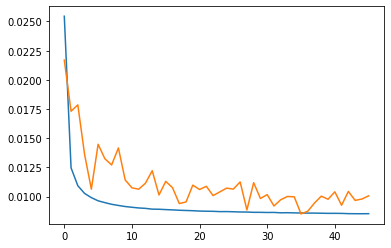

In [12]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])

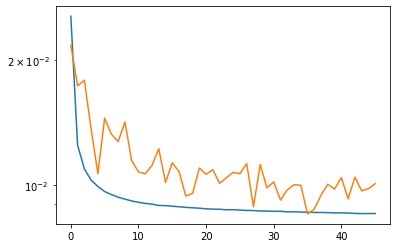

In [13]:
plt.plot(hist3.history['loss'])
plt.plot(hist3.history['val_loss'])
plt.yscale('log')

In [14]:
mypreds3 = model3.predict(X3_test,batch_size=1000)

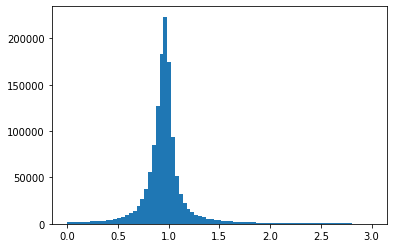

In [15]:
_,_,_=plt.hist(mypreds3[:,0]/Y3_test[:,0],bins=np.linspace(0,3,80))

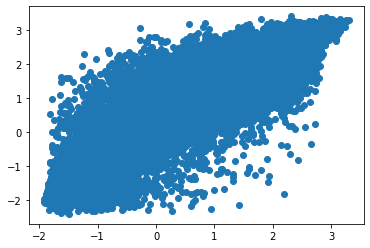

In [16]:
plt.scatter(mypreds3[:,0],Y3_test[:,0])

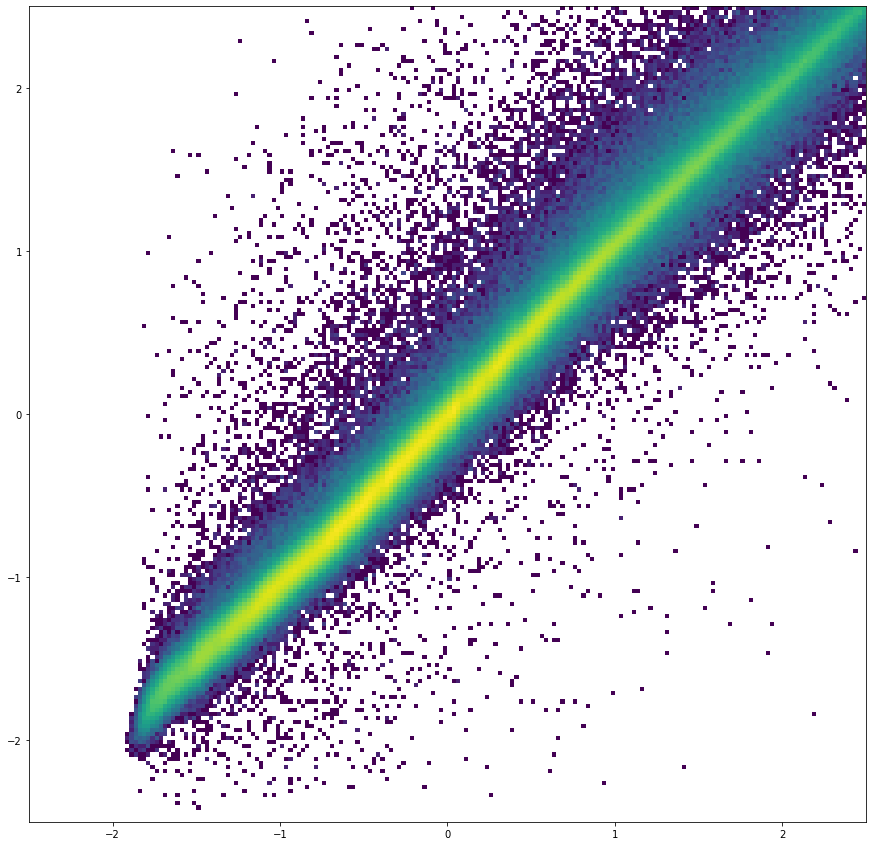

In [17]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
ax.hist2d(mypreds3[:,0],Y3_test[:,0],bins=200, norm=mpl.colors.LogNorm(), range=([-2.5,2.5],[-2.5,2.5]))
plt.show()

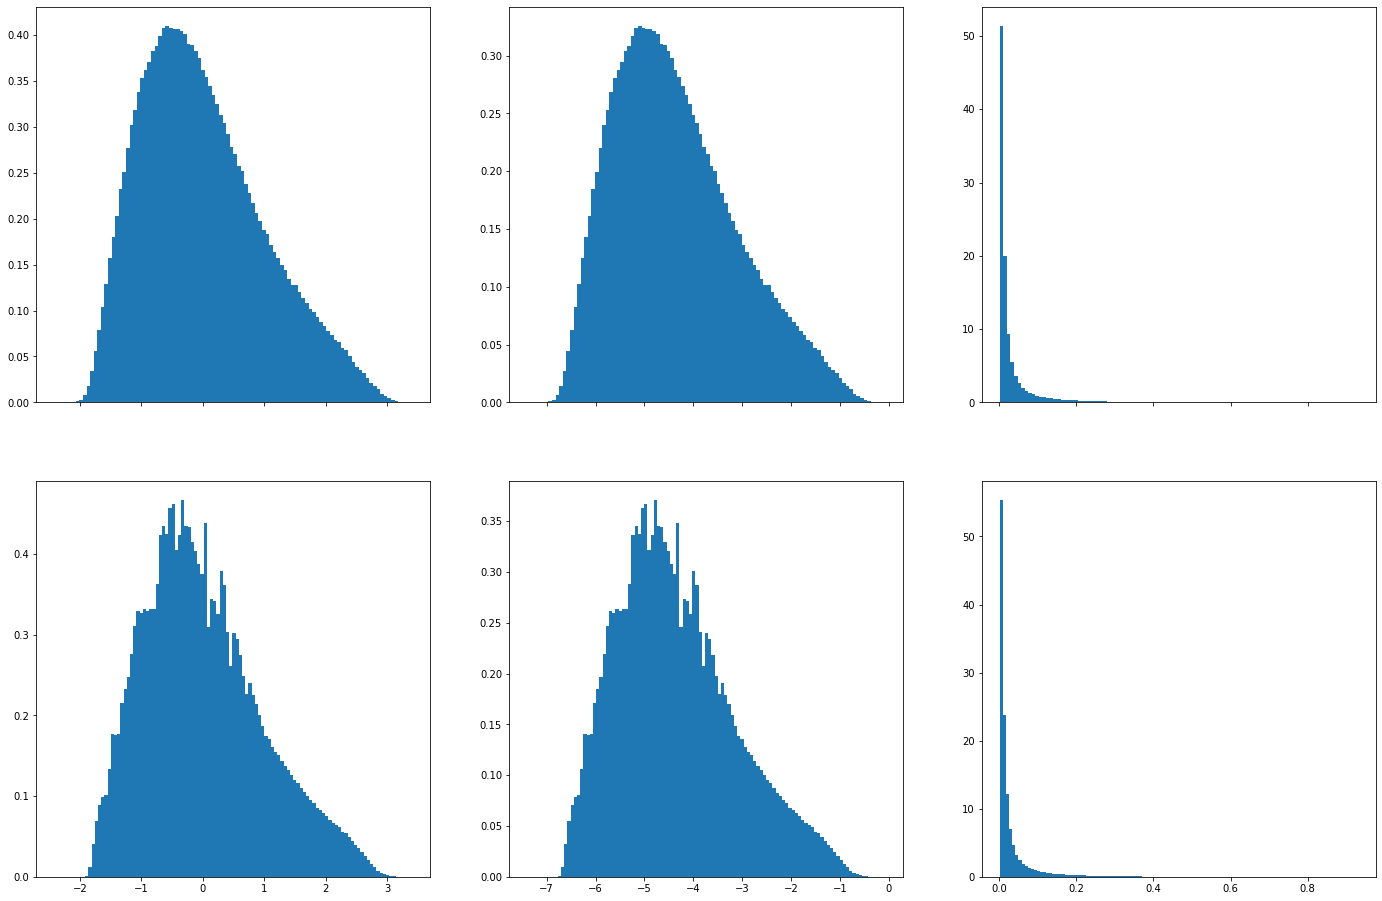

In [18]:
fig,ax = plt.subplots(2,3,figsize=(24,16), sharex='col')

ax[0][0].hist(Y3_test[:,0],density=True,bins=100)
ax[0][1].hist(scalerY3.inverse_transform(Y3_test)[:,0],density=True,bins=100)
ax[0][2].hist(np.exp(scalerY3.inverse_transform(Y3_test)[:,0]),density=True,bins=100)

ax[1][0].hist(mypreds3[:,0],density=True,bins=100)
ax[1][1].hist(scalerY3.inverse_transform(mypreds3)[:,0],density=True,bins=100)
ax[1][2].hist(np.exp(scalerY3.inverse_transform(mypreds3)[:,0]),density=True,bins=100)

plt.show()

## Plots of pred/true of training target variable : log(x)

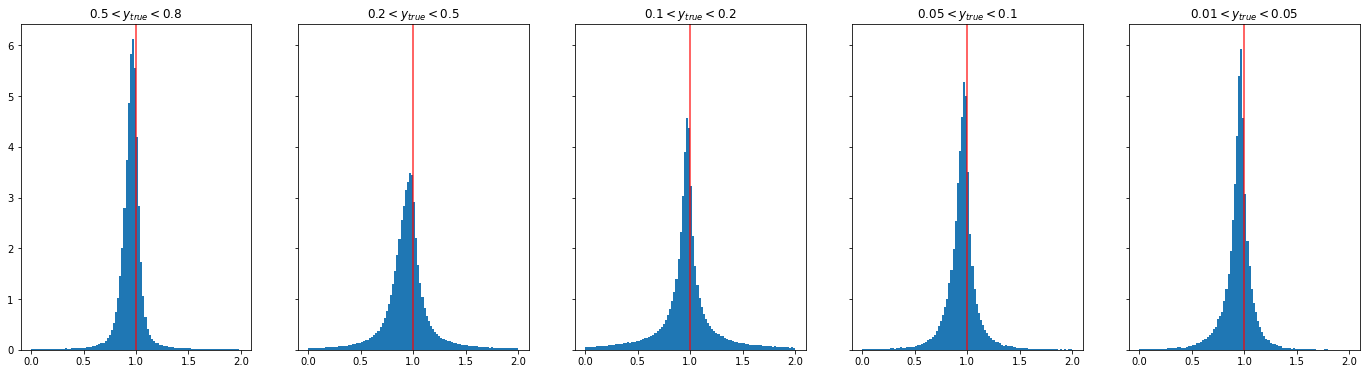

In [19]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(mypreds3[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)]/Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds3[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)]/Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds3[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)]/Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds3[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)]/Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds3[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)]/Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()



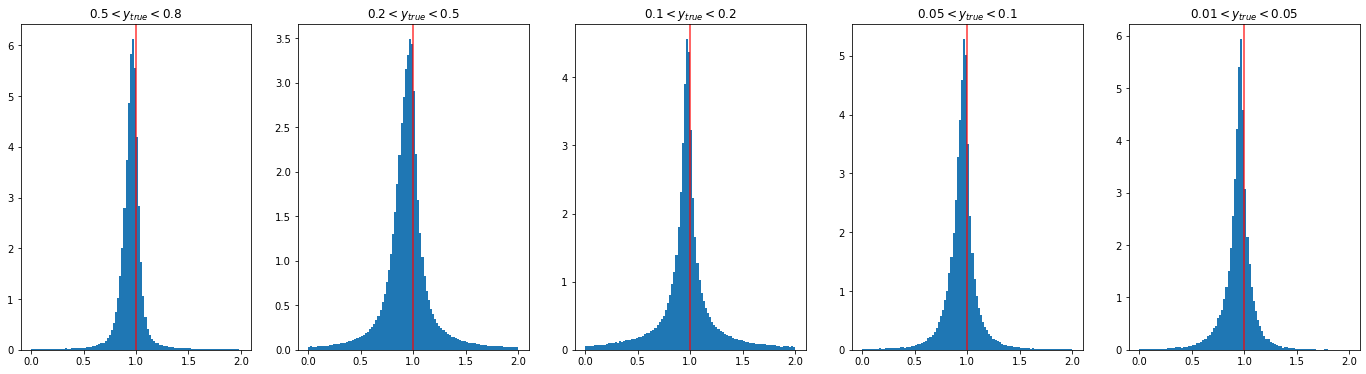

In [20]:
fig,ax = plt.subplots(1,5,figsize=(24,6))

ax[0].hist(mypreds3[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)]/Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(mypreds3[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)]/Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(mypreds3[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)]/Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(mypreds3[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)]/Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(mypreds3[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)]/Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

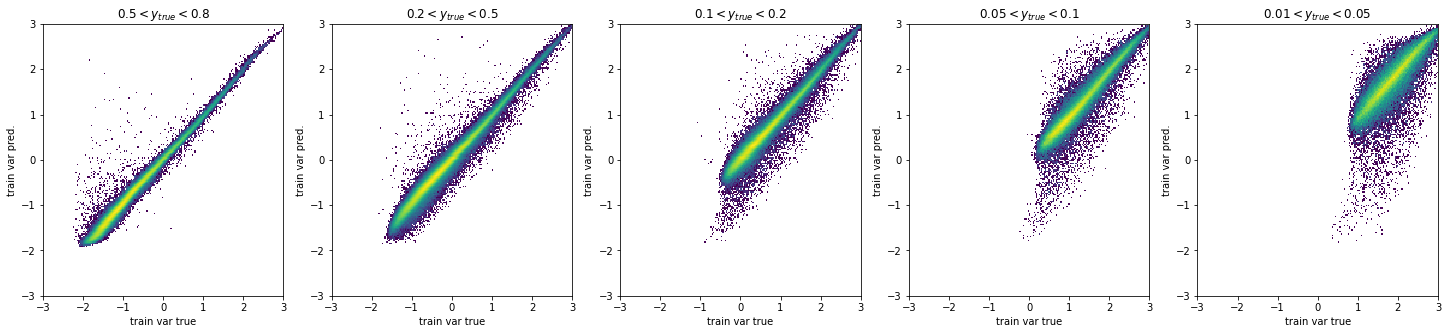

In [21]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( Y3_test[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],
              mypreds3[:,0][(GY3_test > 0.5)*(GY3_test < 0.8)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())

ax[1].hist2d( Y3_test[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],
              mypreds3[:,0][(GY3_test > 0.2)*(GY3_test < 0.5)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())


ax[2].hist2d( Y3_test[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],
              mypreds3[:,0][(GY3_test > 0.1)*(GY3_test < 0.2)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())


ax[3].hist2d( Y3_test[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],
              mypreds3[:,0][(GY3_test > 0.05)*(GY3_test < 0.1)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())


ax[4].hist2d( Y3_test[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],
              mypreds3[:,0][(GY3_test > 0.01)*(GY3_test < 0.05)],                
              density=True,bins=200,range=([-3,3],[-3,3]), norm=mpl.colors.LogNorm())





ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('train var pred.')
    ax[i].set_xlabel('train var true')


    
plt.show()

## Plots of predicted and true physics variable : x

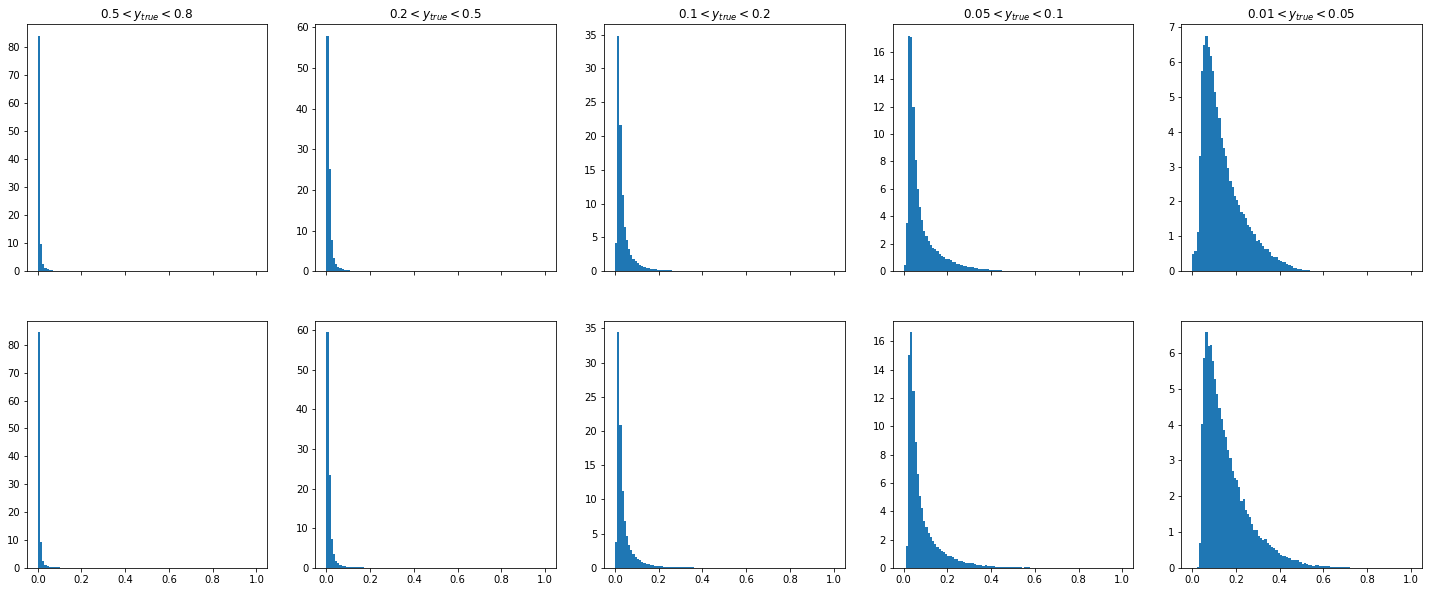

In [22]:
fig,ax = plt.subplots(2,5,figsize=(25,10),sharex='col')

ax[0][0].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)],density=True,bins=100,range=(0,1))
ax[0][1].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)],density=True,bins=100,range=(0,1))
ax[0][2].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)],density=True,bins=100,range=(0,1))
ax[0][3].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)],density=True,bins=100,range=(0,1))
ax[0][4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)],density=True,bins=100,range=(0,1))

ax[1][0].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,1))
ax[1][1].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,1))
ax[1][2].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,1))
ax[1][3].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,1))
ax[1][4].hist(np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,1))


ax[0][0].set_title('$0.5<y_{true}<0.8$')
ax[0][1].set_title('$0.2<y_{true}<0.5$')
ax[0][2].set_title('$0.1<y_{true}<0.2$')
ax[0][3].set_title('$0.05<y_{true}<0.1$')
ax[0][4].set_title('$0.01<y_{true}<0.05$')


    
plt.show()

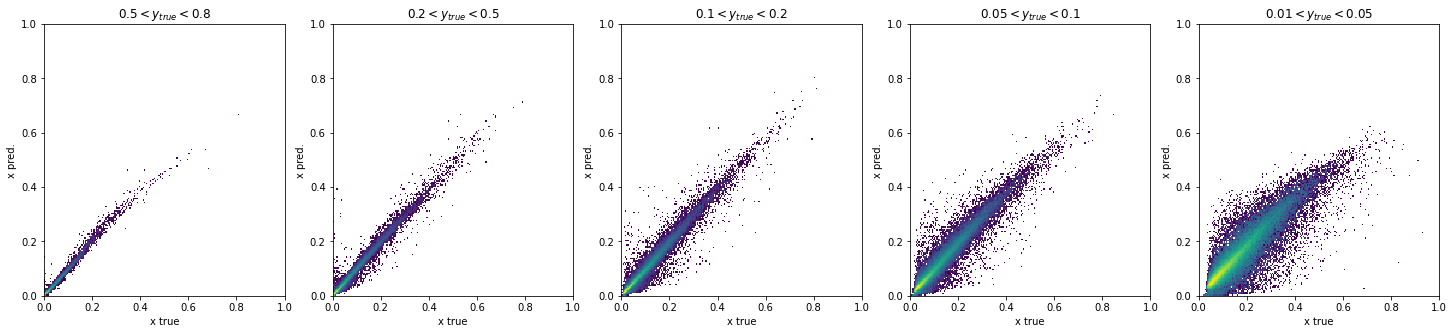

In [23]:
fig,ax = plt.subplots(1,5,figsize=(25,5))

ax[0].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())

ax[1].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[2].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[3].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())


ax[4].hist2d( np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],
              np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)],                
              density=True,bins=200,range=([0,1],[0,1]), norm=mpl.colors.LogNorm())





ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')

for i in range(5):
    ax[i].set_ylabel('x pred.')
    ax[i].set_xlabel('x true')


    
plt.show()

## Plots of pred/true of physics variable:  x

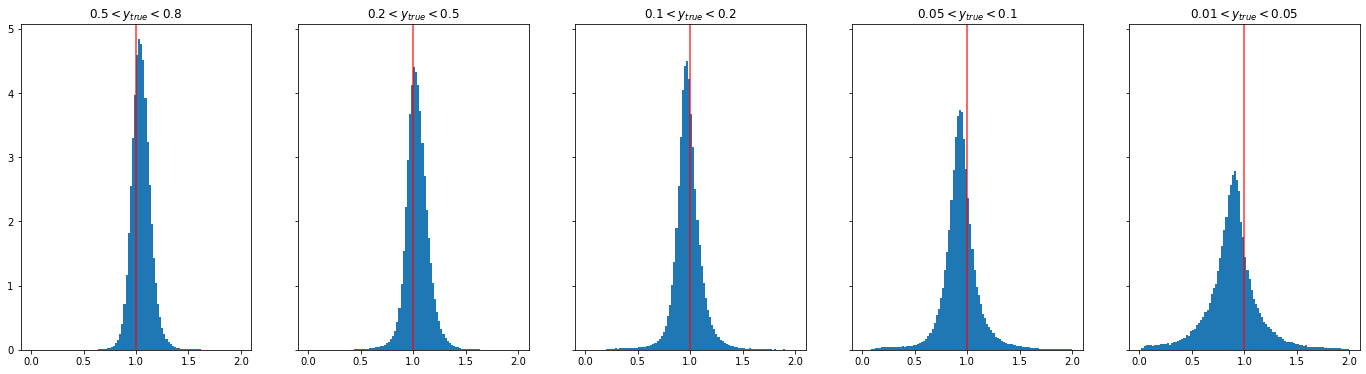

In [24]:
fig,ax = plt.subplots(1,5,figsize=(24,6),sharey='row')

ax[0].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(0,2))
ax[1].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(0,2))
ax[2].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(0,2))
ax[3].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(0,2))
ax[4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(0,2))

ax[0].set_title('$0.5<y_{true}<0.8$')
ax[1].set_title('$0.2<y_{true}<0.5$')
ax[2].set_title('$0.1<y_{true}<0.2$')
ax[3].set_title('$0.05<y_{true}<0.1$')
ax[4].set_title('$0.01<y_{true}<0.05$')


for i in range(5):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
    
plt.show()

## Conclusions 

Larger training stats don't necessarily give far superior results.


## Standard comparison plots

In [25]:

pandas_df.eval('s = 4*27.6*920', inplace=True)
pandas_df.eval('x_e = Q2_e/(s*y_e)',inplace=True)
pandas_df.eval('x_da = Q2_da/(s*y_da)',inplace=True)
pandas_df.eval('x_sigma = Q2_sigma/(s*y_sigma)',inplace=True)
pandas_df.eval('x_esigma = x_sigma',inplace=True)



pandas_df.eval('gen_x= gen_Q2/(s*gen_y)', inplace=True)   

pandas_df.eval('xe_ratio = x_e/gen_x',inplace=True)
pandas_df.eval('xda_ratio = x_da/gen_x',inplace=True)
pandas_df.eval('xsigma_ratio = x_sigma/gen_x',inplace=True)
pandas_df.eval('xesigma_ratio = x_esigma/gen_x',inplace=True)
        

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


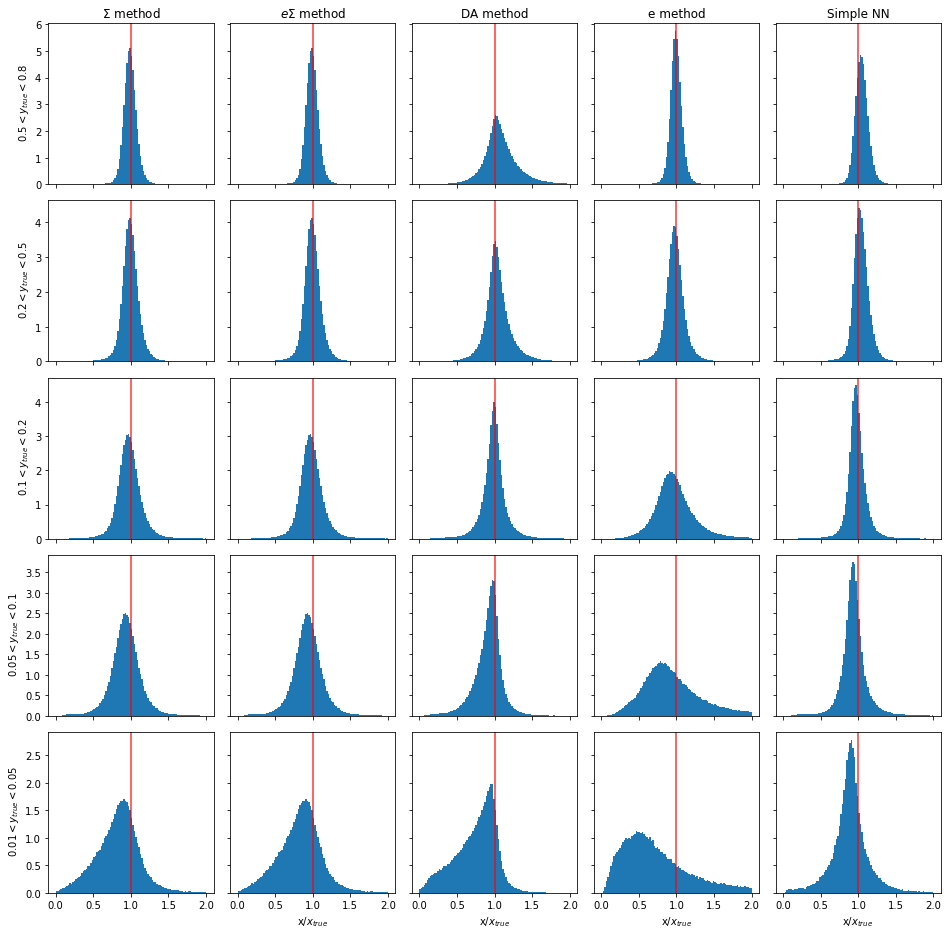

In [26]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)

xmin=0.
xmax=2.

for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(pandas_df.query(ybins[i])['xsigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[1 + 5*i].hist(pandas_df.query(ybins[i])['xesigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[2 + 5*i].hist(pandas_df.query(ybins[i])['xda_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[3 + 5*i].hist(pandas_df.query(ybins[i])['xe_ratio'],density=True,bins=100,range=(xmin,xmax))

ax[4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[9].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[14].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[19].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[24].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(xmin,xmax))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')
ax[4].set_title('Simple NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()

## Make standard plots with the x axis zoomed in more near 1.

['gen_y>0.5 and gen_y<0.8' 'gen_y>0.2 and gen_y<0.5'
 'gen_y>0.1 and gen_y<0.2' 'gen_y>0.05 and gen_y<0.1'
 'gen_y>0.01 and gen_y<0.05']
gen_y>0.5 and gen_y<0.8
gen_y>0.2 and gen_y<0.5
gen_y>0.1 and gen_y<0.2
gen_y>0.05 and gen_y<0.1
gen_y>0.01 and gen_y<0.05


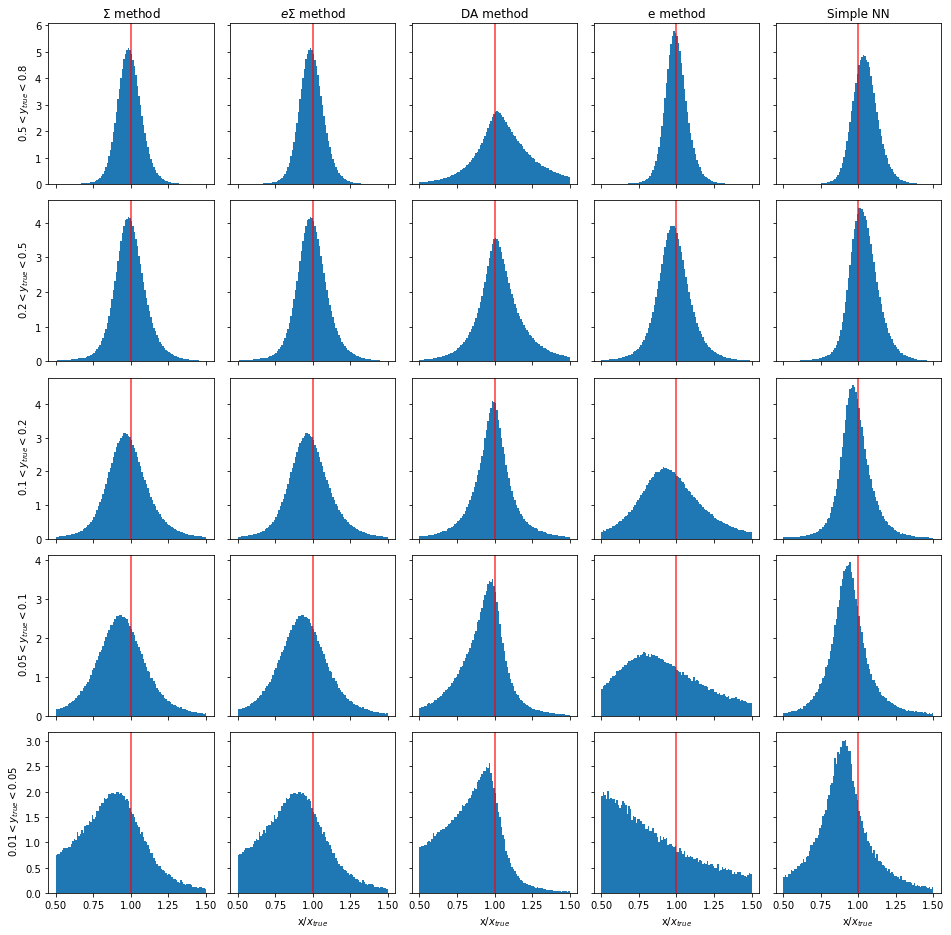

In [27]:
fig,ax = plt.subplots(5,5,figsize=(16,16),sharey='row',sharex=True)
ax = ax.flatten()
ybins = np.array(['gen_y>0.5 and gen_y<0.8', 'gen_y>0.2 and gen_y<0.5',
                  'gen_y>0.1 and gen_y<0.2', 'gen_y>0.05 and gen_y<0.1','gen_y>0.01 and gen_y<0.05'])
print(ybins)

xmin=0.5
xmax=1.5

for i in range(5):
    print(ybins[i])
    ax[0 + 5*i].hist(pandas_df.query(ybins[i])['xsigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[1 + 5*i].hist(pandas_df.query(ybins[i])['xesigma_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[2 + 5*i].hist(pandas_df.query(ybins[i])['xda_ratio'],density=True,bins=100,range=(xmin,xmax))
    ax[3 + 5*i].hist(pandas_df.query(ybins[i])['xe_ratio'],density=True,bins=100,range=(xmin,xmax))

ax[4].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.5)*(GY3_test < 0.8)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.5)*(GY3_test < 0.8)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[9].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.2)*(GY3_test < 0.5)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.2)*(GY3_test < 0.5)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[14].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.1)*(GY3_test < 0.2)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.1)*(GY3_test < 0.2)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[19].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.05)*(GY3_test < 0.1)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.05)*(GY3_test < 0.1)][:,0],density=True,bins=100,range=(xmin,xmax))
ax[24].hist(np.exp(scalerY3.inverse_transform(mypreds3[:,0]))[(GY3_test > 0.01)*(GY3_test < 0.05)]/np.exp(scalerY3.inverse_transform(Y3_test))[(GY3_test > 0.01)*(GY3_test < 0.05)][:,0],density=True,bins=100,range=(xmin,xmax))
    
for i in range(len(ax.flatten())):
    ax[i].axvline(1.0,color='red',lw=2,alpha=0.6)
#ax[1].set_title(r"$\bf{ATHENA}$"+' full simulation [DD4hep] \n Pythia8+Geant4, NC DIS 18x275 GeV, $Q^{2}>100$ GeV$^{2}$',fontsize=29)
    ax[i].set_xticks([],minor=True)
    ax[i].set_yticks([], minor=True)
    #ax[i].set_yscale('log')
    # for minor ticks
    #ax[i].set_xticks([], minor=True)

plt.subplots_adjust(wspace=0.1, hspace=0.1)

ax[3].set_title('e method')
ax[2].set_title('DA method')
ax[0].set_title('$\Sigma$ method')
ax[1].set_title('$e\Sigma$ method')
ax[4].set_title('Simple NN')


ax[0].set_ylabel(' $0.5<y_{true}<0.8$')
ax[4+1].set_ylabel(' $0.2<y_{true}<0.5$')
ax[8+1+1].set_ylabel(' $0.1<y_{true}<0.2$')
ax[12+1+1+1].set_ylabel(' $0.05<y_{true}<0.1$')
ax[16+1+1+1+1].set_ylabel(' $0.01<y_{true}<0.05$')
ax[-1].set_xlabel(r'x/$x_{true}$ ')

ax[-2].set_xlabel(r'x/$x_{true}$ ')
ax[-3].set_xlabel(r'x/$x_{true}$ ')
ax[-4].set_xlabel(r'x/$x_{true}$ ')


plt.show()

In [28]:
tf.keras.models.save_model(model3,"model_output_h1_3g")

INFO:tensorflow:Assets written to: model_output_h1_3g/assets
